# OONI Data Analysis - Nepal 2022

This is a brief analysis of the OONI dataset for Nepal in 2022.

In [173]:
# Basic Imports
import pandas as pd
import numpy as np
import os
from urllib.parse import urlparse

# Plotting Imports
from matplotlib import pyplot as plt
import seaborn as sns

# Statstools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [164]:
# Plot configuration
sns.set_style('dark')
sns.set_palette("tab10")
palette = sns.color_palette()

In [7]:
# Paths
data_dir = '../../../Data/NP/processed/2022/'

## Web Connectivity

The web connectivity test checks whether specific sites are reachable by the client, and if it is unreachable, which specific types of mechanisms of blocking could be potential causes.

The specific test types are given by:
* `dns` - The DNS server does not resolve the site properly
  * This is used commonly to
* `httpdiff` - The page accessed is not the page the original page
  * This is commonly a "blocked" page displayed instead of the real page
* `httpfail` - The http fails explicitly
* `tcp` - TCP connection has failed

In [155]:
# Get the web connectivity data and clean it
web_connectivity = pd.read_csv(os.path.join(data_dir, 'webconnectivity.csv'))
web_connectivity['date'] = pd.to_datetime(web_connectivity['date'])
web_connectivity = web_connectivity.set_index('date')

# Standardize URLs
def url_standardize(url):
    p = urlparse(url)
    b = p.netloc.split('.')
    c = '.'.join(b[len(b)-2:])  # Remove any www
    return c+p.path
    
web_connectivity['input'] = web_connectivity['input'].map(url_standardize)
web_connectivity

,probe_asn,http_experiment_failure,x_dns_flags,status_code_match,resolver_asn,headers_match,blocking,body_length_match,input,control_failure,title_match,accessible,x_null_null_flags,x_blocking_flags,body_proportion,dns_consistency,dns_experiment_failure
date,,,,,,,,,,,,,,,,,
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,fteproxy.org/,NaN,True,True,NaN,NaN,1.000000,consistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,sbc.net/,NaN,True,True,NaN,NaN,1.000000,consistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,ecequality.org/,NaN,True,True,NaN,NaN,1.000000,inconsistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,episcopalchurch.org/,NaN,True,True,NaN,NaN,1.000000,consistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,icrw.org/,NaN,True,True,NaN,NaN,0.999723,consistent,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,AS23752,NaN,NaN,True,AS23752,True,False,True,facebook.com/,NaN,NaN,True,NaN,NaN,0.975015,consistent,NaN
2022-12-31,AS23752,NaN,NaN,False,AS23752,True,False,NaN,instagram.com/,NaN,NaN,True,NaN,NaN,0.000000,consistent,NaN
2022-12-31,AS23752,NaN,NaN,True,AS23752,True,False,NaN,youtube.com/,NaN,NaN,True,NaN,NaN,0.000000,consistent,NaN


In [11]:
# Filter data into specific blocking methods
dns_events = web_connectivity[web_connectivity['blocking'] == 'dns']
httpdiff_events = web_connectivity[web_connectivity['blocking'] == 'http-diff']
httpfail_events = web_connectivity[web_connectivity['blocking'] == 'http-failure']
tcp_events = web_connectivity[web_connectivity['blocking'] == 'tcp_ip']

In [135]:
# Create date range for all records
dr = pd.date_range('01-01-2022', '01-01-2023', freq='D')
dvals = pd.Series(index=dr).fillna(0.0)
dvals.index.name = 'date'

In [160]:
# Compute rolling totals
k=1

total_events = dvals.copy()
tmp = web_connectivity.groupby(web_connectivity.index).size()
total_events[tmp.index] = tmp
total_events = total_events.rolling(window=k).sum().dropna()

total_dns = dvals.copy()
tmp = dns_events.groupby(dns_events.index).size()
total_dns[tmp.index] = tmp
total_dns = total_dns.rolling(window=k).sum().dropna()

total_httpdiff = dvals.copy()
tmp = httpdiff_events.groupby(httpdiff_events.index).size()
total_httpdiff[tmp.index] = tmp
total_httpdiff = total_httpdiff.rolling(window=k).sum().dropna()

total_httpfail = dvals.copy()
tmp = httpfail_events.groupby(httpfail_events.index).size()
total_httpfail[tmp.index] = tmp
total_httpfail = total_httpfail.rolling(window=k).sum().dropna()

total_tcp = dvals.copy()
tmp = tcp_events.groupby(tcp_events.index).size()
total_tcp[tmp.index] = tmp
total_tcp = total_tcp.rolling(window=k).sum().dropna()

### Time Series Modeling

We first want to check to see if our data is actually stationary using the Augmented Dickey-Fuller Test, which is a statistical test that tries to evaluate whether the null hypothesis that a particular time series dataset is non-stationary, meaning that the data is a function of time.  If the test's p-value is below a significance threshold, we can reject this and assume our data is stationary, which makes modeling the relationship a bit less complicated.

In [207]:
# Check if the data is stationary
adf_dns = adfuller(total_dns)
adf_httpdiff = adfuller(total_httpdiff)
adf_httpfail = adfuller(total_httpfail)
adf_tcp = adfuller(total_tcp)
adf_tests = pd.DataFrame({
    'dns': [adf_dns[0], adf_dns[1]],
    'httpdiff': [adf_httpdiff[0], adf_httpdiff[1]],
    'httpfail': [adf_httpfail[0], adf_httpfail[1]],
    'tcp': [adf_tcp[0], adf_tcp[1]]
}, index=["ADF Statistic", "p-value"])
print("ADF Tests")
adf_tests
#print(f"ADF statistics: {adf_dns[0]}, {adf_httpdiff[0]}, {adf_httpfail[0]}, {adf_tcp[0]}")
#print(f"ADF p-values: {adf_dns[1]}, {adf_httpdiff[1]}, {adf_httpfail[1]}, {adf_tcp[1]}")

ADF Tests


,dns,httpdiff,httpfail,tcp
ADF Statistic,-4.110553,-1.920132,-6.959515e+00,-5.699942e+00
p-value,0.000930,0.322651,9.241936e-10,7.717434e-07


Since the p-value of the ADF Test is greater than a traditional cutoff of $0.05$ for HTTP-Diff, we cannot safely reject the the null hypothesis that the series data is stationary in this specific case, however it is low enough in all other cases that we can reject the null hypothesis.  This means that the data in these blocking events is likely to be stationary in the 0th order.

#### ARMA Modeling

We choose a basic Auto-Regressive Moving Average (ARMA) model for the data which are stationary at their base order (0).  In order to explore the parameterization of the model, we use the Partial Autocorrelation estimate for each.

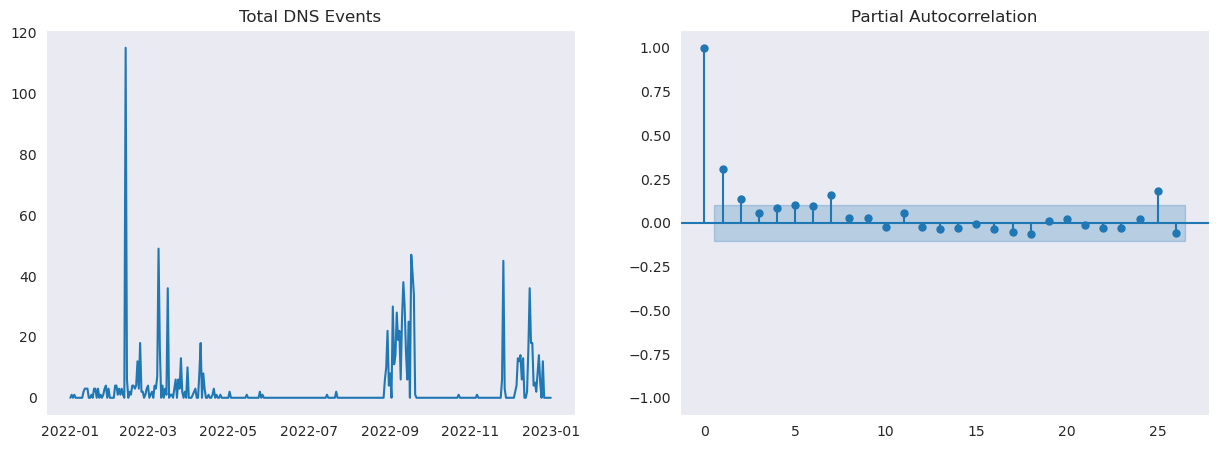

In [169]:
# Set plot options
plt.rcParams['figure.figsize'] = [15, 5]

# Type
name = 'DNS'

# Set current color
cur_color = palette[0]

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(total_dns, color=cur_color)
axes[0].set_title(f'Total {name} Events')
plot_pacf(total_dns.dropna(), ax=axes[1], color=cur_color)
axes[1].set(ylim=(-1.1,1.1))
for line in axes[1].get_lines():
    line.set_color(cur_color)
for marker in axes[1].collections:
    marker.set_color(cur_color)
plt.show()

As seen in the partial autocorrelation plot, there are potential peaks above the threshold in 0,1,2,7, and 25 day moving windows.  This suggests that a model that captures this order of information will represent the true data.  We try to fit ARMA models with these orders, then evaluate the AIC, BIC for each to determine the best model to use.

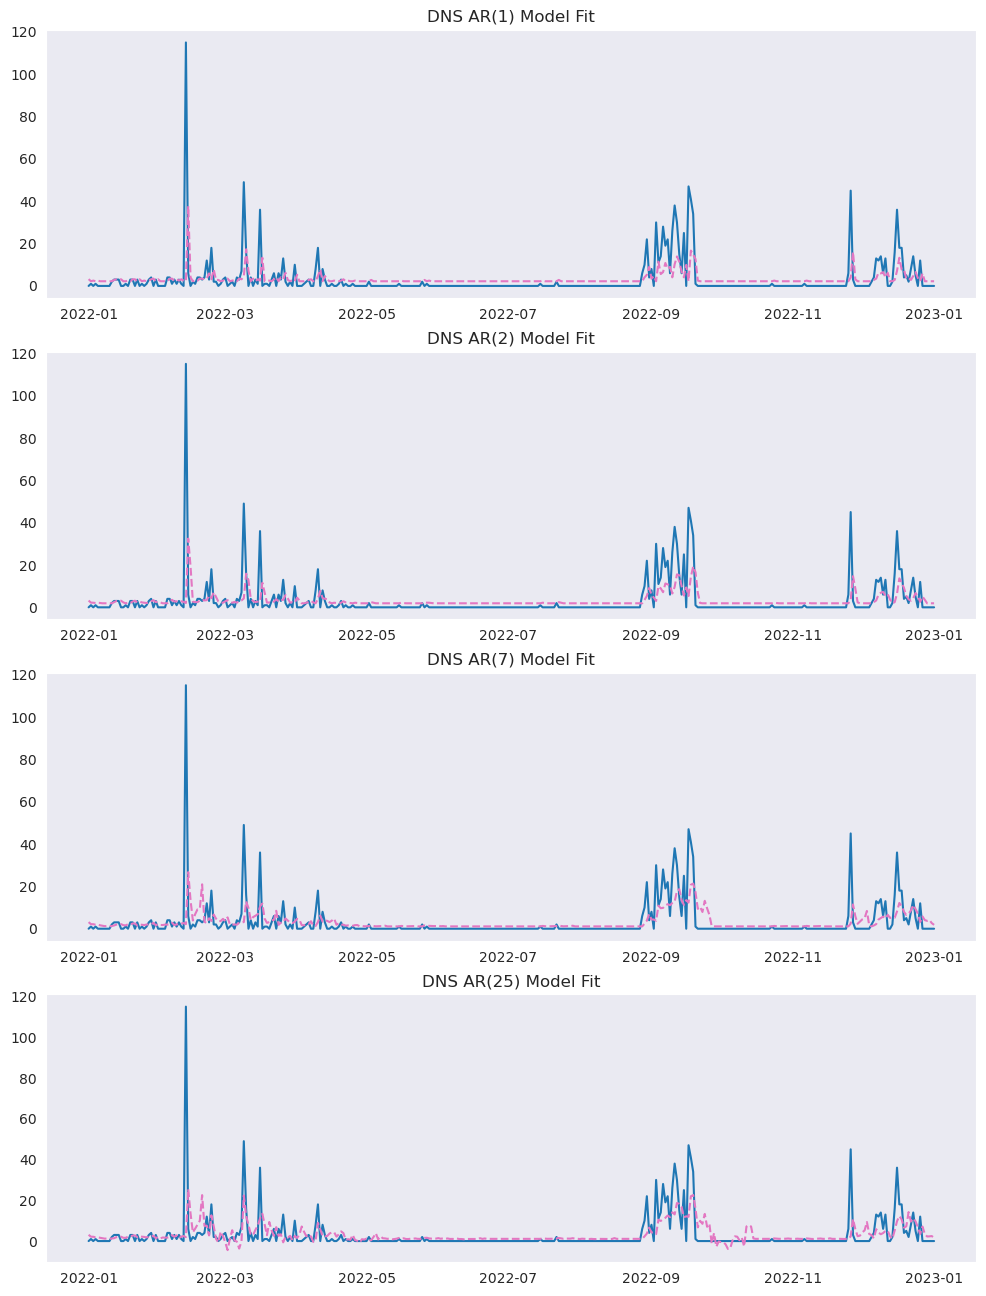

In [198]:
# Try out various orders
ar_orders = [1, 2, 7, 25]
fitted_models = {}
plt.figure(figsize=(12,4*len(ar_orders)))
for i, order in enumerate(ar_orders):
    ar_model = ARIMA(total_dns, order=(order, 0, 0)) # d=0, q=0 -> AR model
    ar_model_fit = ar_model.fit()
    fitted_models[order] = ar_model_fit
    plt.subplot(len(ar_orders), 1, i+1)
    plt.plot(total_dns, color=cur_color)
    plt.plot(ar_model_fit.fittedvalues, color=palette[6], linestyle='--')
    plt.title(f'{name} AR({order}) Model Fit')

In [209]:
# Get the AIC and BIC of each model
for order in ar_orders:
    print(f"[{name}] - AIC, BIC for AR({order}): {fitted_models[order].aic}, {fitted_models[order].bic}")

[HTTP-Fail] - AIC, BIC for AR(1): 2110.0073788711247, 2121.715278871329
[HTTP-Fail] - AIC, BIC for AR(2): 2071.983676562093, 2087.5942098956984
[HTTP-Fail] - AIC, BIC for AR(7): 2075.2609226880045, 2110.3846226886167
[HTTP-Fail] - AIC, BIC for AR(25): 2096.945901386322, 2202.317001388159


The model with the lowest AIC is the AR(7) model, however the model with the lowest BIC is the AR(2) model.  Depending on whether we want to prioritize accuracy at the expense of using more data points for fitting, we would choose either the 2nd or 7th order models for the DNS data.

In [206]:
fitted_models[2].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1031.992
Date:                Wed, 12 Mar 2025   AIC                           2071.984
Time:                        03:55:34   BIC                           2087.594
Sample:                    01-01-2022   HQIC                          2078.187
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5195      0.896      1.696      0.090      -0.237       3.276
ar.L1          0.1692      0.036      4.654      0.000       0.098       0.240
ar.L2          0.3211      0.020     16.315      0.000       0.283       0.360
sigma2        16.4552      0.607     27.119      0.000      15.266      17.645
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):              8784.87
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             3.82
Prob(H) (two-sided):                  0.07   Kurtosis:                        25.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

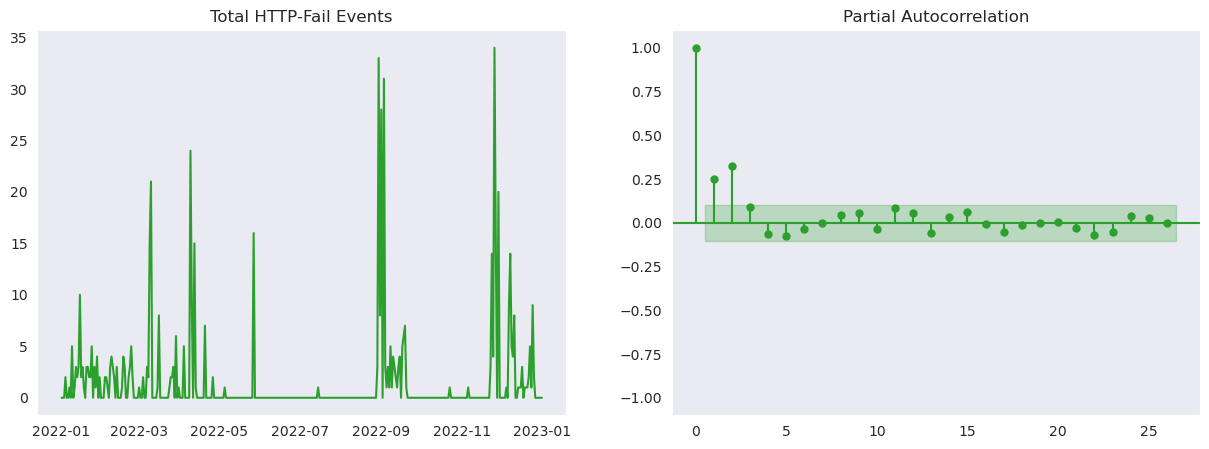

In [203]:
# Set plot options
plt.rcParams['figure.figsize'] = [15, 5]

# Type
name = 'HTTP-Fail'

# Set current color
cur_color = palette[2]

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(total_httpfail, color=cur_color)
axes[0].set_title(f'Total {name} Events')
plot_pacf(total_httpfail.dropna(), ax=axes[1], color=cur_color)
axes[1].set(ylim=(-1.1,1.1))
for line in axes[1].get_lines():
    line.set_color(cur_color)
for marker in axes[1].collections:
    marker.set_color(cur_color)
plt.show()

As seen in the partial autocorrelation plot, there are potential peaks above the threshold in 1st, and 2nd orders.

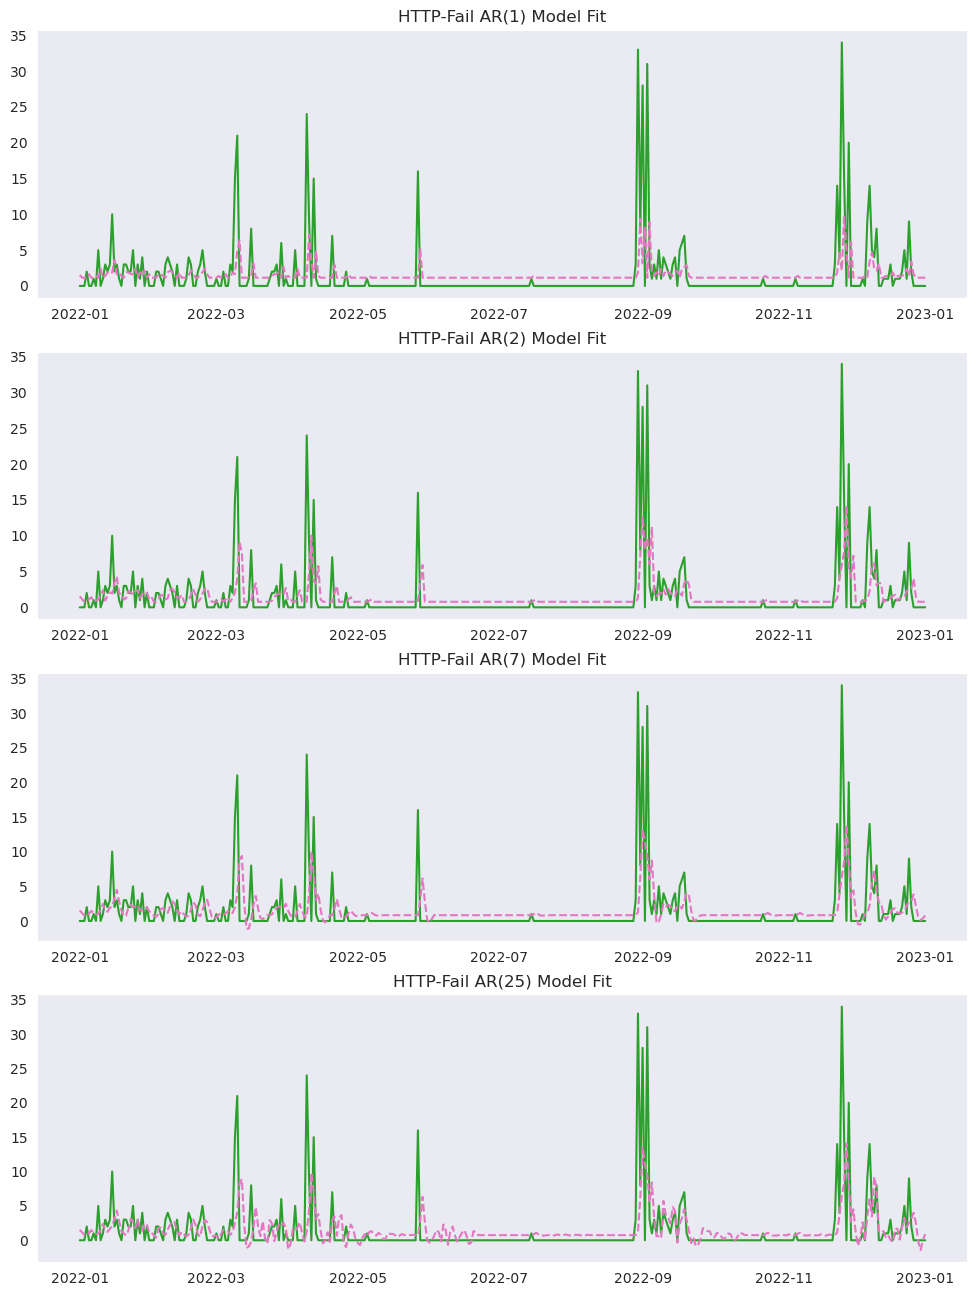

In [204]:
# Try out various orders
ar_orders = [1, 2, 7, 25]
fitted_models = {}
plt.figure(figsize=(12,4*len(ar_orders)))
for i, order in enumerate(ar_orders):
    ar_model = ARIMA(total_httpfail, order=(order, 0, 0)) # d=0, q=0 -> AR model
    ar_model_fit = ar_model.fit()
    fitted_models[order] = ar_model_fit
    plt.subplot(len(ar_orders), 1, i+1)
    plt.plot(total_httpfail, color=cur_color)
    plt.plot(ar_model_fit.fittedvalues, color=palette[6], linestyle='--')
    plt.title(f'{name} AR({order}) Model Fit')

In [202]:
# Get the AIC and BIC of each model
for order in ar_orders:
    print(f"[{name}] - AIC, BIC for AR({order}): {fitted_models[order].aic}, {fitted_models[order].bic}")

[HTTP-Fail] - AIC, BIC for AR(1): 2110.0073788711247, 2121.715278871329
[HTTP-Fail] - AIC, BIC for AR(2): 2071.983676562093, 2087.5942098956984
[HTTP-Fail] - AIC, BIC for AR(7): 2075.2609226880045, 2110.3846226886167
[HTTP-Fail] - AIC, BIC for AR(25): 2096.945901386322, 2202.317001388159


#### ARIMA Modeling

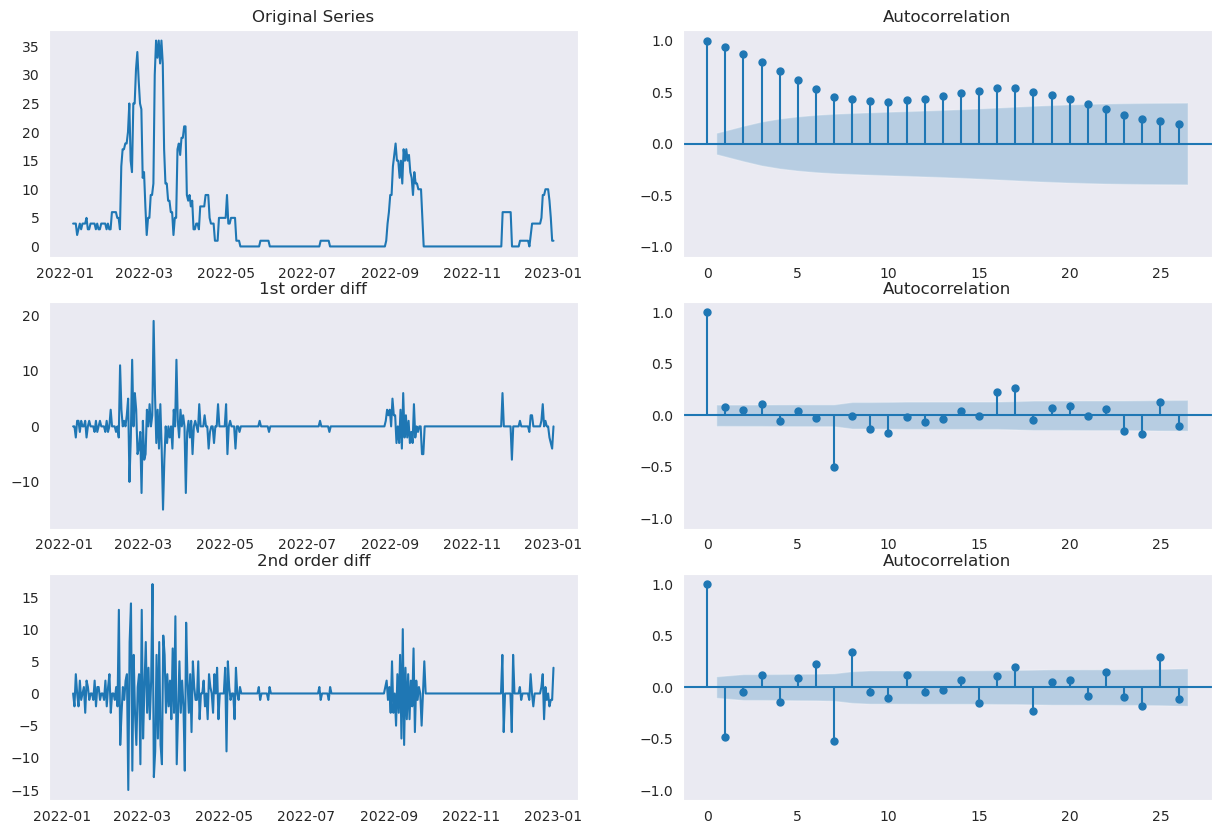

In [152]:
# Set plot options
plt.rcParams['figure.figsize'] = [15, 10]

# Plot Original Data
fig, axes = plt.subplots(3,2, sharex=False)
#axes[0, 0].plot(total_dns)
axes[0, 0].plot(total_httpdiff)
#axes[0, 0].plot(total_httpfail)
#axes[0, 0].plot(total_tcp)
axes[0, 0].set_title('Original Series')
#plot_acf(total_dns, ax=axes[0, 1])
plot_acf(total_httpdiff, ax=axes[0, 1])
#plot_acf(total_httpfail, ax=axes[0, 1])
#plot_acf(total_tcp, ax=axes[0, 1])
axes[0, 1].set_ylim(-1.1, 1.1)

# 1st order differencing
#diff_1_dns = total_dns.diff().dropna()
diff_1_httpdiff = total_httpdiff.diff().dropna()
#diff_1_httpfail = total_httpfail.diff().dropna()
#diff_1_tcp = total_tcp.diff().dropna()
#axes[1, 0].plot(diff_1_dns)
axes[1, 0].plot(diff_1_httpdiff)
#axes[1, 0].plot(diff_1_httpfail)
#axes[1, 0].plot(diff_1_tcp)
axes[1, 0].set_title('1st order diff')
axes[1, 0].set_ymargin(0.1)
#plot_acf(diff_1_dns, ax=axes[1, 1])
plot_acf(diff_1_httpdiff, ax=axes[1, 1])
#plot_acf(diff_1_httpfail, ax=axes[1, 1])
#plot_acf(diff_1_tcp, ax=axes[1, 1])
axes[1, 1].set_ylim(-1.1, 1.1)

# 2nd order differencing
#diff_2_dns = diff_1_dns.diff().dropna()
diff_2_httpdiff = diff_1_httpdiff.diff().dropna()
#diff_2_httpfail = diff_1_httpfail.diff().dropna()
#diff_2_tcp = diff_1_tcp.diff().dropna()
#axes[2, 0].plot(diff_2_dns)
axes[2, 0].plot(diff_2_httpdiff)
#axes[2, 0].plot(diff_2_httpfail)
#axes[2, 0].plot(diff_2_tcp)
axes[2, 0].set_title('2nd order diff')
#plot_acf(diff_2_dns, ax=axes[2, 1])
plot_acf(diff_2_httpdiff, ax=axes[2, 1])
#plot_acf(diff_2_httpfail, ax=axes[2, 1])
#plot_acf(diff_2_tcp, ax=axes[2, 1])
axes[2,1].set_ylim(-1.1, 1.1)

# Show the plot
plt.show()

From these plots we can infer that all of the cases become stationary after first order differences.

Next we find the other term of the ARIMA model using Partial Autocorrelation.

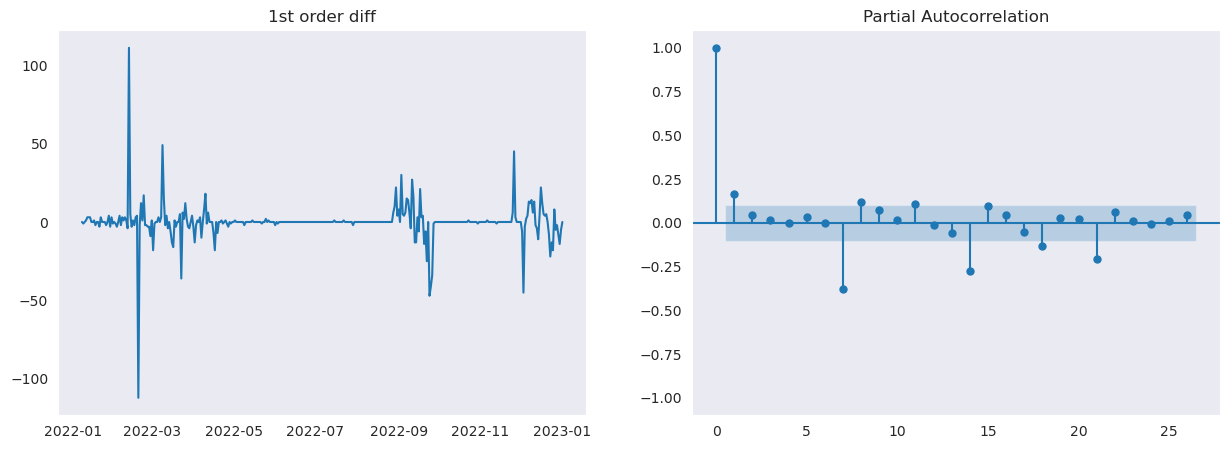

In [114]:
# Set plot options
plt.rcParams['figure.figsize'] = [15, 5]

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(diff_1_dns)
axes[0].set_title('1st order diff')
plot_pacf(diff_1_dns.dropna(), ax=axes[1])
axes[1].set(ylim=(-1.1,1.1))
plt.show()

Looking at the partial autocorrelation

In [147]:
model_dns = ARIMA(total_dns, order=(1,2,1))
model_dns_fit = model_dns.fit()
print(model_dns_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  360
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1385.848
Date:                Wed, 12 Mar 2025   AIC                           2777.695
Time:                        02:18:16   BIC                           2789.337
Sample:                    01-07-2022   HQIC                          2782.325
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1677      0.038      4.394      0.000       0.093       0.243
ma.L1         -0.9999      2.489     -0.402      0.688      -5.879       3.879
sigma2       132.8047    330.450      0.402      0.6